# Project - Historic Weather Data Analysis
For simulation of our analysis we are taking our dataset from : Dataset location
We will be considering data from 2010 to 2019 of California State, which is around 86,000 rows and 16 columns.
In this project we have worked with HDFS and Spark, Spark MLlib.


The idea of the Project is:
    1. From the source, retrieve and dataset.
    2. Load the  dataset to HDFS.
    3. From HDFS retrieve the data using Spark
    4. Perform Spark Ml Lib Linear Regression, SARIMA model and Sklearn Linear Regression
    5. Produce visualisations based on the analysis.

In [1]:
#Importing required libraries 
import findspark
findspark.init('D:/spark')

In [2]:
#Import Spark and Mllib Libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import mean as _mean, col, count
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType
import warnings
import itertools
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
import datetime
from pylab import rcParams
%matplotlib inline
from pyspark.ml.tuning import ParamGridBuilder
from subprocess import check_output
from pyspark.sql.functions import mean as _mean, col, count
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.regression import RandomForestRegressor
warnings.filterwarnings("ignore")
import statsmodels.api as sm
import matplotlib
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'


In [3]:
spark = SparkSession.builder.appName('ml-bank').getOrCreate()
sc = spark.sparkContext

# Prediction Using Spark ML LIB Random Forest Regressor

In [4]:
#loading the dataframe from hdfs
df = spark.read.format('com.databricks.spark.csv').\
                       options(header='true', \
                       inferschema='true').\
            load('hdfs://localhost:9000/BigData/california.csv',header=True);
df.show()


+--------------+--------+--------+------------+-------+--------+--------+-----------------+--------+-------+-------+-------+---------+----------+----------+----------+------------+----------+--------+--------+--------+-----+----------+-------------+-------------+
|     date_time|maxtempC|mintempC|totalSnow_cm|sunHour|uvIndex5|uvIndex6|moon_illumination|moonrise|moonset|sunrise| sunset|DewPointC|FeelsLikeC|HeatIndexC|WindChillC|WindGustKmph|cloudcover|humidity|precipMM|pressure|tempC|visibility|winddirDegree|windspeedKmph|
+--------------+--------+--------+------------+-------+--------+--------+-----------------+--------+-------+-------+-------+---------+----------+----------+----------+------------+----------+--------+--------+--------+-----+----------+-------------+-------------+
| 1/1/2010 0:00|      14|       1|         0.0|    8.7|       3|       1|              100| 7:16 PM|8:50 AM|8:00 AM|5:51 PM|       -4|         0|         2|         0|          14|         7|      65|     0.0

In [5]:
#selecting the needed columns 
pds = df.select('date_time','mintempC', 'DewPointC','windspeedKmph', 'HeatIndexC', 'tempC','maxtempC')
pda=pds.toPandas()
pda['date_time']= pd.to_datetime(pda['date_time'])
pda = pda.set_index('date_time') 

#resampling to monthly
pda=pda.resample('MS').mean()

#renaming the maxtempC column as label which needs to be prodicted
pda.rename(columns = {'maxtempC':'label'}, inplace = True)
b=pda.to_csv("c.csv")

dfnew = spark.read.format('com.databricks.spark.csv').\
                       options(header='true', \
                       inferschema='true').\
            load('c.csv',header=True);

dfnew.show()

+----------+------------------+-------------------+------------------+------------------+------------------+------------------+
| date_time|          mintempC|          DewPointC|     windspeedKmph|        HeatIndexC|             tempC|             label|
+----------+------------------+-------------------+------------------+------------------+------------------+------------------+
|2010-01-01|2.7419354838709675|-0.5510752688172043| 8.231182795698924| 6.771505376344086| 6.739247311827957| 12.64516129032258|
|2010-02-01|3.4285714285714284| 0.5550595238095238| 9.650297619047619|7.7351190476190474| 7.693452380952381|13.571428571428571|
|2010-03-01| 4.129032258064516| -4.493279569892473|12.620967741935484| 9.629032258064516|  9.61021505376344|16.580645161290324|
|2010-04-01| 5.166666666666667|-1.8194444444444444|12.970833333333333|11.168055555555556|11.208333333333334|              18.7|
|2010-05-01| 7.645161290322581| -3.168010752688172|14.758064516129032| 14.59005376344086|14.719086021505

In [6]:
dfnew = dfnew.select('mintempC', 'DewPointC','windspeedKmph', 'HeatIndexC', 'tempC','label')
cols = dfnew.columns

feature_list = []
for col in dfnew.columns:
    if col == 'label':
        continue
    else:
        feature_list.append(col)

assembler = VectorAssembler(inputCols=feature_list, outputCol="features")


rf = RandomForestRegressor(labelCol="label", featuresCol="features")


In [7]:
pipeline = Pipeline(stages=[assembler, rf])

paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]) \
    .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 3)]) \
    .build()
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(),
                          numFolds=3)

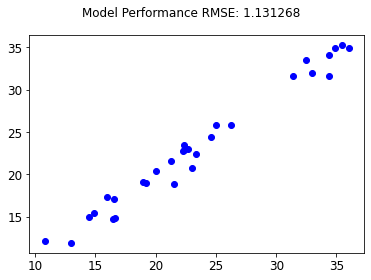

In [8]:
(trainingData, testData) = dfnew.randomSplit([0.8, 0.2])

cvModel = crossval.fit(trainingData)
predictions = cvModel.transform(testData)


evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

rmse = evaluator.evaluate(predictions)
rfResult = predictions.toPandas()

plt.plot(rfResult.label, rfResult.prediction, 'bo')

plt.suptitle("Model Performance RMSE: %f" % rmse)
plt.show()

In [9]:

rfResult

,mintempC,DewPointC,windspeedKmph,HeatIndexC,tempC,label,features,prediction
0,0.892857,-4.599702,10.437500,6.218750,6.196429,13.000000,"[0.8928571428571429, -4.599702380952381, 10.43...",11.896083
1,0.935484,-7.138441,12.420699,5.586022,5.561828,10.774194,"[0.9354838709677419, -7.138440860215054, 12.42...",12.076382
2,4.000000,-10.456989,8.766129,9.227151,9.213710,16.483871,"[4.0, -10.456989247311828, 8.766129032258064, ...",14.729384
3,4.129032,-4.493280,12.620968,9.629032,9.610215,16.580645,"[4.129032258064516, -4.493279569892473, 12.620...",14.796288
4,4.225806,-6.962366,12.662634,8.924731,8.897849,14.483871,"[4.225806451612903, -6.962365591397849, 12.662...",14.923177
5,5.142857,-5.558036,13.854167,9.718750,9.688988,14.857143,"[5.142857142857143, -5.558035714285714, 13.854...",15.374709
6,6.100000,-2.170833,14.076389,12.752778,12.812500,21.500000,"[6.1, -2.1708333333333334, 14.07638888888889, ...",18.813134
7,6.225806,-6.270161,12.388441,10.931452,10.907258,16.516129,"[6.225806451612903, -6.270161290322581, 12.388...",17.030292
8,7.400000,-4.476389,8.118056,13.540278,13.205556,19.200000,"[7.4, -4.476388888888889, 8.118055555555555, 1...",18.966648
9,7.645161,-3.168011,14.758065,14.590054,14.719086,23.000000,"[7.645161290322581, -3.168010752688172, 14.758...",20.812069


# Prediction Using Sarima

In [10]:
#loading the data from hdfs to an RDD
rdd = sc.textFile('hdfs://localhost:9000/BigData/california.csv')
rdd = rdd.map(lambda line: line.split(','))
rdd = rdd.map(lambda p:(p[0],p[1],p[2],p[3],p[4],p[5],p[6],p[7],p[8],p[9]
                        ,p[10],p[11],p[12],p[13],p[14],p[15],p[16],p[17],p[18],p[19],p[20],p[21],p[22],p[23],p[24]))
rdd.collect()

[('date_time',
  'maxtempC',
  'mintempC',
  'totalSnow_cm',
  'sunHour',
  'uvIndex',
  'uvIndex',
  'moon_illumination',
  'moonrise',
  'moonset',
  'sunrise',
  'sunset',
  'DewPointC',
  'FeelsLikeC',
  'HeatIndexC',
  'WindChillC',
  'WindGustKmph',
  'cloudcover',
  'humidity',
  'precipMM',
  'pressure',
  'tempC',
  'visibility',
  'winddirDegree',
  'windspeedKmph'),
 ('1/1/2010 0:00',
  '14',
  '1',
  '0',
  '8.7',
  '3',
  '1',
  '100',
  '7:16 PM',
  '8:50 AM',
  '8:00 AM',
  '5:51 PM',
  '-4',
  '0',
  '2',
  '0',
  '14',
  '7',
  '65',
  '0',
  '1028',
  '2',
  '10',
  '30',
  '7'),
 ('1/1/2010 1:00',
  '14',
  '1',
  '0',
  '8.7',
  '3',
  '1',
  '100',
  '7:16 PM',
  '8:50 AM',
  '8:00 AM',
  '5:51 PM',
  '-3',
  '0',
  '2',
  '0',
  '14',
  '8',
  '68',
  '0',
  '1028',
  '2',
  '10',
  '43',
  '6'),
 ('1/1/2010 2:00',
  '14',
  '1',
  '0',
  '8.7',
  '3',
  '1',
  '100',
  '7:16 PM',
  '8:50 AM',
  '8:00 AM',
  '5:51 PM',
  '-3',
  '0',
  '2',
  '0',
  '13',
  '9',
 

In [11]:
#rdd.collect()
#Create a Pandas dataframe from RDD
dfs = rdd.toDF()
df=dfs.toPandas()

In [12]:
new_header = df.iloc[0] #grab the first row for the header
df = df[1:] #take the data less the header row
df.columns = new_header
df= df[['date_time','maxtempC','mintempC','totalSnow_cm','DewPointC','HeatIndexC','humidity','precipMM','pressure','tempC','windspeedKmph']]
df.columns = ['Date','Tmax','Tmin','SnowDepth','Dewpt','HeatIndx','Humidity','Precipitation','Pressure','Tobserved','Windspeed']

In [13]:
df['Tmax'] = df['Tmax'].astype(int)
df['Tmin'] = df['Tmin'].astype(int)
df['Dewpt'] = df['Dewpt'].astype(int)
df['HeatIndx'] = df['HeatIndx'].astype(int)
df['Humidity'] = df['Humidity'].astype(int)
df['Pressure'] = df['Pressure'].astype(int)
df['Tobserved'] = df['Tobserved'].astype(int)
df['Windspeed'] = df['Windspeed'].astype(int)
df['SnowDepth'] = df['SnowDepth'].astype(float)
df['Precipitation'] = df['Precipitation'].astype(float)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88392 entries, 1 to 88392
Data columns (total 11 columns):
Date             88392 non-null object
Tmax             88392 non-null int32
Tmin             88392 non-null int32
SnowDepth        88392 non-null float64
Dewpt            88392 non-null int32
HeatIndx         88392 non-null int32
Humidity         88392 non-null int32
Precipitation    88392 non-null float64
Pressure         88392 non-null int32
Tobserved        88392 non-null int32
Windspeed        88392 non-null int32
dtypes: float64(2), int32(8), object(1)
memory usage: 4.7+ MB


In [15]:
#Adding Tavg to the column list
df.insert(3,column='Tavg',value = (df['Tmax']+df['Tmin'])/2,allow_duplicates = True)
# df['DATE'] = df['DATE'].str.slice(0, 5)
df.head(2)

,Date,Tmax,Tmin,Tavg,SnowDepth,Dewpt,HeatIndx,Humidity,Precipitation,Pressure,Tobserved,Windspeed
1,1/1/2010 0:00,14,1,7.5,0.0,-4,2,65,0.0,1028,2,7
2,1/1/2010 1:00,14,1,7.5,0.0,-3,2,68,0.0,1028,2,6


In [16]:
# Change the dataframe relative to date 
df['Date']= pd.to_datetime(df['Date'])
df = df.set_index('Date')      



Glimpse of the data

In [17]:
# the dataset is resampled to monthly data where the mean of the
# respective month is taken for the monthly values. Also null values are filled with
# most recent previous observation.
y = df['Windspeed']    
# change argument of resample() to 'D' for daily analysis
y = y.resample('MS').mean()

print(y['2010-02-01':])

Date
2010-02-01     9.650298
2010-03-01    12.620968
2010-04-01    12.970833
2010-05-01    14.758065
2010-06-01    14.700000
                ...    
2019-08-01    14.954301
2019-09-01    14.904167
2019-10-01    10.490591
2019-11-01     8.118056
2019-12-01     9.920699
Freq: MS, Name: Windspeed, Length: 119, dtype: float64


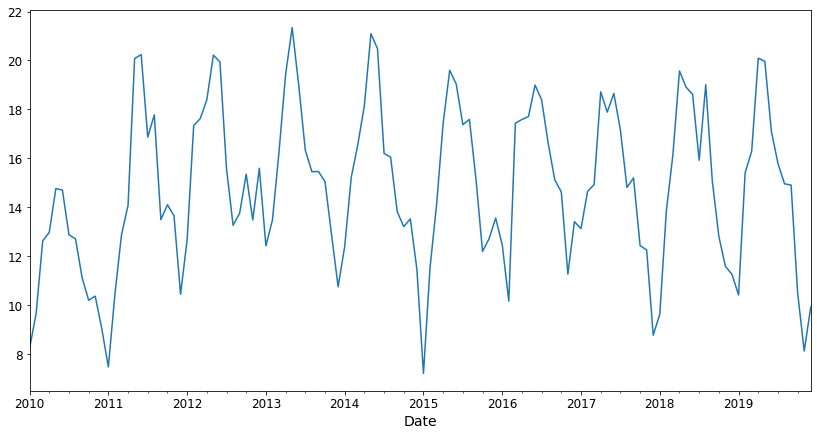

In [18]:
#How the data actually looks like converting the data to monthly data
y.plot(figsize=(14,7))

In [19]:
#For our model we have 9 years dataset, so we are taking data till 2016-dec for training and rest for testing
#i.e., 36 months of data for testing
y_train =y[:len(y)-36] #80% of the data for training
y_test=y[len(y)-36:] #20% of data for testing

In [20]:
#Last two values in the training dataset
y_train[-2:]

Date
2016-11-01    11.259722
2016-12-01    13.408602
Freq: MS, Name: Windspeed, dtype: float64

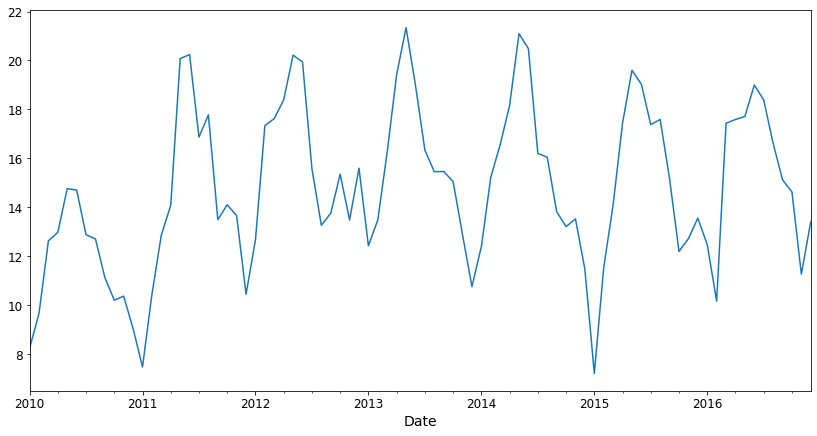

In [21]:
#How the training dataset looks like
y_train.plot(figsize=(14,7))

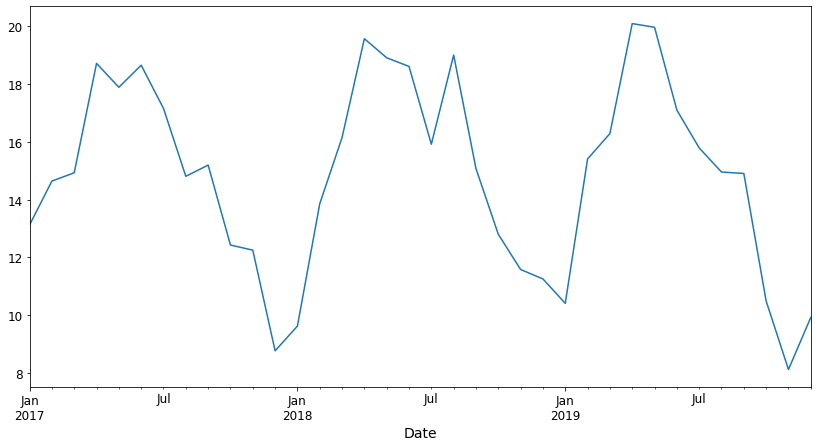

In [22]:
#Plot of testing dataset
y_test.plot(figsize=(14,7))

# To do the SARIMA model we will be follow these steps:
    1. Decomposing the time series data.
    2. Checking the stationarity of the data.
    3. Interpreting ACF and PACF for data correlation.
    4. Determine p,d,q values.
    5. Adding seasonality -> S-ARIMA
    6. Adding holiday factore: SARIMA-X

<Figure size 432x288 with 0 Axes>

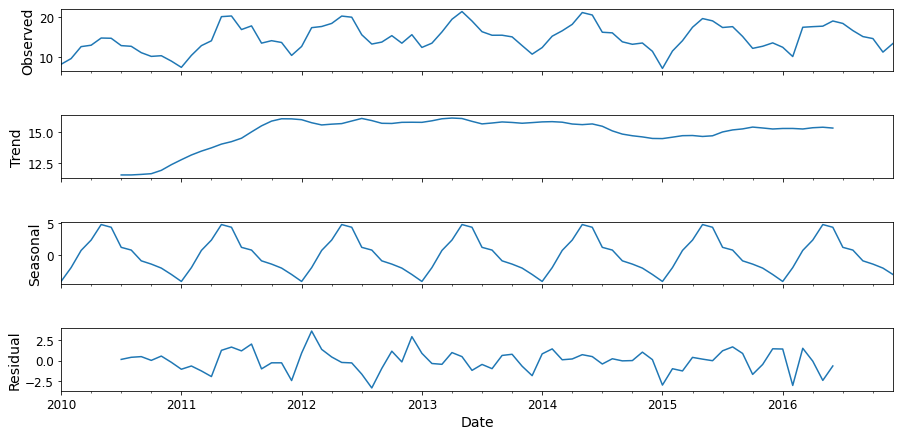

In [23]:
#Decomposing time series data to see trend, seasonality and residuals
tsa_decompose = sm.tsa.seasonal_decompose(y_train,model='additive')
fig = plt.figure()
fig = tsa_decompose.plot()
fig.set_size_inches(14,7)
plt.show()


#Since we have the seasonality we are using SARIMA model.

In [24]:
y_train =y[:len(y)-36]
y_train

Date
2010-01-01     8.231183
2010-02-01     9.650298
2010-03-01    12.620968
2010-04-01    12.970833
2010-05-01    14.758065
                ...    
2016-08-01    16.610215
2016-09-01    15.119444
2016-10-01    14.620968
2016-11-01    11.259722
2016-12-01    13.408602
Freq: MS, Name: Windspeed, Length: 84, dtype: float64

Do a AD (Augumented Dickey) Fuller test to check the stationarity of the time series data
Stationarity: Checking if statistical observations are consistent

In [25]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(y_train)
print('ADF Statistics: ',result[0])
print('p-value: ',result[1])
print('Critical Values:')
for key,value in result[4].items():
    print('\t',(key,value))

ADF Statistics:  -2.8375906194533402
p-value:  0.05310159215078722
Critical Values:
	 ('1%', -3.524624466842421)
	 ('5%', -2.9026070739026064)
	 ('10%', -2.5886785262345677)


Info:
based on p-value and relationship between ADF statistics and critical values,
we can determine the stationarity of the data:
   
If test statistics > critical_value -> data is stationary
    
If p-Vaule <= 0.05 -> data is stationary

ACF and PACF to find the timeseries correlation

Note: If there is any recurring pattern is observed betwee n ACF and PACF plots,
we could suspect that there would be some sort of seasonal pattern going on and can 
proceed to SARIMA taking seasonality of time series data into account.

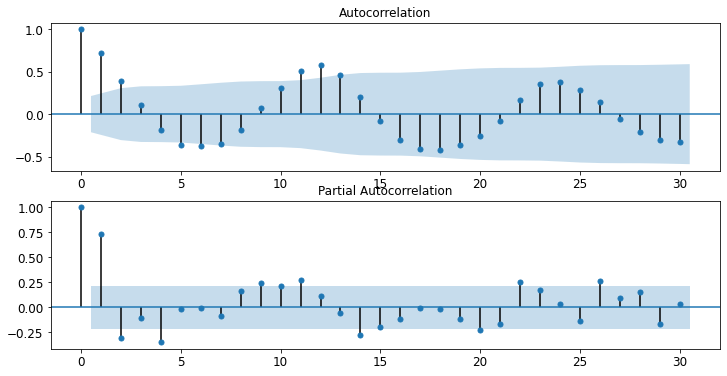

In [26]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
#ACF : Autocorrelation of timeseries  by lag
# Cumulative effect to the correlation factor
#PACF : Individual effect to the correlation factor

# Creating a correlation between the series and one-step ahead of the series
#The purpose of plotting acf and pacf is to check if we can predict a future value using past data or not
#Here we are predicting the future value using past 20 values i'e., lag 20
fig,ax = plt.subplots(2,figsize=(12,6))
ax[0] = plot_acf(y_train,ax=ax[0],lags=30)
ax[1] = plot_pacf(y_train,ax=ax[1],lags=30)

Finding suitable p,d,q -> (ar term, integral term, ma term)

In [27]:
#Calculate AIC: A Information Criteria to fit pdq and PDQ of SARIMA model, 
#Makesure to choose the metric with the lowest AIC value
# since we have no idea which p,d,q will be suitable for our model
# we will generate daat for p,d,q values run on our training dataset and choose the one with least AIC metric.
p = d = q = range(0,2)
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0],x[1],x[2],12) for x in list(itertools.product(p,d,q))]
print('SARIMAX{}x{}'.format(pdq[1],seasonal_pdq[1]))

SARIMAX(0, 0, 1)x(0, 0, 1, 12)


In [28]:
aic_dict = dict()
aic_full = pd.DataFrame(np.zeros((6,6), dtype=float))
for pm in pdq:
    for pm_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(y_train,
                                            order=pm,
                                            seasonal_order=pm_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
        try:
            model_aic = mod.fit(disp=False)
            print('ARIMA{}x{}12 - AIC:{}'.format(pm,pm_seasonal,model_aic.aic))
            aic_dict.update({(pm,pm_seasonal):model_aic.aic})
        except :
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:689.2656534055999
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:533.490615760598
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:340.10979747157484
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:263.9234780601092
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:344.64634848726797
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:325.82550335086245
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:273.530294148062
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:253.775804054343
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:585.0099994751721
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:455.4554828432308
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:318.5936077078246
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:238.78884653062607
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:327.87081253877466
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:299.54850007357334
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:260.50848732937294
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:236.84573570487504
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:374.56527583708856
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:321.6635234175034
ARIM

In [29]:
#Sort the aic metric dictionary and find the pdq & PDQ values for seasonal analysis 
#based on lowest AIC metric value
{k:v for k,v in sorted(aic_dict.items(), key=lambda x:x[1])}

{((1, 0, 1), (0, 1, 1, 12)): 231.6908220832594,
 ((0, 0, 1), (1, 1, 1, 12)): 236.84573570487504,
 ((0, 1, 1), (0, 1, 1, 12)): 237.10007953783244,
 ((1, 1, 1), (0, 1, 1, 12)): 237.6162809785557,
 ((1, 0, 1), (1, 1, 1, 12)): 237.75609950598925,
 ((0, 0, 1), (0, 1, 1, 12)): 238.78884653062607,
 ((1, 0, 0), (0, 1, 1, 12)): 243.57282883259035,
 ((1, 0, 1), (1, 1, 0, 12)): 244.03106513793628,
 ((1, 1, 1), (1, 1, 1, 12)): 245.3582647846418,
 ((0, 1, 1), (1, 1, 1, 12)): 245.52276317633786,
 ((1, 0, 0), (1, 1, 1, 12)): 247.19940431211006,
 ((1, 1, 1), (1, 1, 0, 12)): 247.57080458847255,
 ((1, 0, 0), (1, 1, 0, 12)): 250.11394553515748,
 ((1, 1, 0), (0, 1, 1, 12)): 250.31958775771508,
 ((0, 1, 0), (0, 1, 1, 12)): 252.06010700520605,
 ((0, 1, 1), (1, 1, 0, 12)): 252.10498722081795,
 ((0, 0, 0), (1, 1, 1, 12)): 253.775804054343,
 ((1, 1, 0), (1, 1, 0, 12)): 255.8662166493072,
 ((1, 1, 0), (1, 1, 1, 12)): 256.37671785163826,
 ((0, 1, 0), (1, 1, 1, 12)): 258.6615283626002,
 ((0, 0, 1), (1, 1, 0, 12))

#Fitting the final model based on lowest AIC
Steps to follow:
    1.fit the model : mod_aic = mod.fit()
    2.Get model presictions : forecast = mod_aic.get_prediction()
    3.Calculate prediction mean : predict = forecast.predicted_mean
    4.Go with the final predicted output : pred_ci = forecast.conf_int()

In [30]:
# Seasonal AutoRegressive Integrated Moving Average(SARIMA) with eXogenous regressors model
#Now fit these parameters to the ARIMA model

mod = sm.tsa.statespace.SARIMAX(y_train,
                                order=(1, 0, 1),#(ar,i,ma)
                                seasonal_order=(0, 1, 1, 12),#(ar,i,ma,no. of months)
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()
print(results.summary().tables[1])

#ar is the ar component
#ma is moving average component
# sigma2 is variance of the residual part


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8780      0.039     22.604      0.000       0.802       0.954
ma.L1         -0.7831      0.097     -8.061      0.000      -0.974      -0.593
ma.S.L12      -1.0001    668.134     -0.001      0.999   -1310.518    1308.518
sigma2         2.1402   1430.157      0.001      0.999   -2800.916    2805.197


Model Diagnostics -> To ensure that none of the assumptions made by the model have been violated.

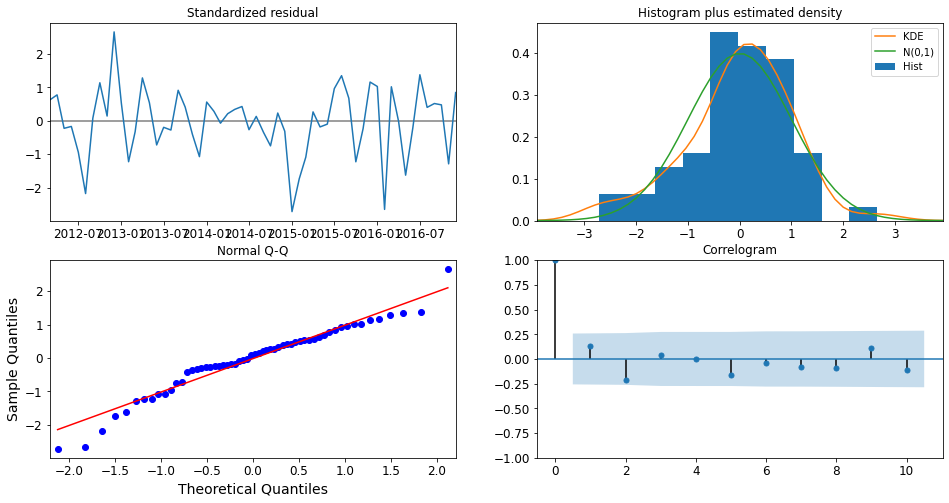

In [31]:
#Generate Model diagnostics and check for any unusual behaviour
results.plot_diagnostics(figsize=(16,8))
plt.show()


Calculate RMSE and produce forecasts by comparing predicted values with real values of time series.

In [32]:


forecast = results.get_prediction(start = pd.to_datetime('2017-01-01'),dynamic=False) #One-step ahead forecasting
# #forecast = results.get_prediction(start = pd.to_datetime('2017-02-01'),dynamic=True,full_results=True) #dynamic forcasting
predictions = forecast.predicted_mean

actual= y_test['2017-01-01':]

mse = ((predictions - actual)**2).mean()
rmse = np.sqrt(mse)

print('The Mean Squared Error of our forecast is {}'.format(mse,2))
print('The Root Mean Squared Error of our forecasts is {}\n'.format(rmse, 2))

The Mean Squared Error of our forecast is 3.961717392868399
The Root Mean Squared Error of our forecasts is 1.990406338632491



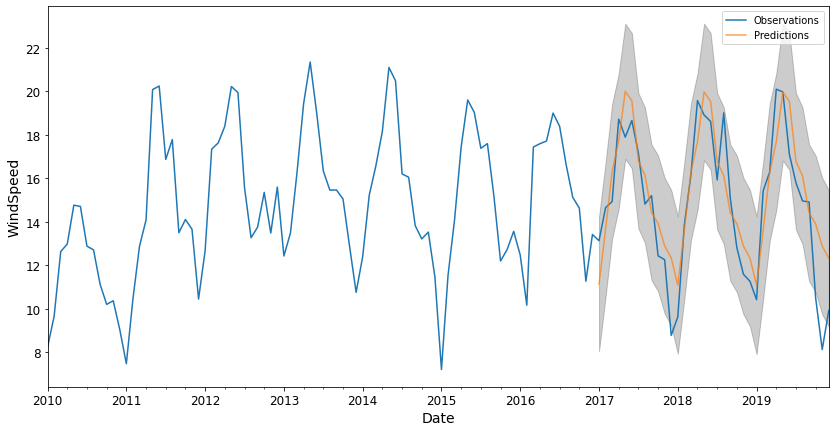

In [33]:
forecast = results.get_forecast(steps = 36)

#predictions and confidence interval
predictions = forecast.predicted_mean
ci = forecast.conf_int()

ax = y.plot(label='Observations',figsize=(16,8))
ax.set_xlabel('Date')
ax.set_ylabel('WindSpeed')
ax.fill_between(ci.index,
             ci.iloc[:, 0],
             ci.iloc[:, 1], color='k', alpha=.2)

predictions.plot(ax = ax,label='Predictions',alpha=.7,figsize=(14,7))

plt.legend()
plt.show()

Based on the one-step and dynamic forecasts, we confirm that the timwseries model is valid.
Check ability to forecast future values ahead in time

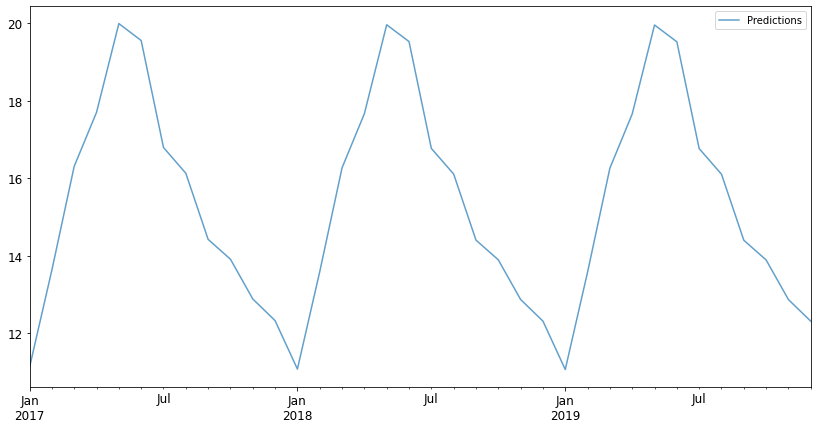

In [34]:
predictions.plot(label='Predictions',alpha=.7,figsize=(14,7))

plt.legend()
plt.show()

In [35]:
#Predicting forecast one year ahead than available
pred_uc = results.get_forecast(steps=48)
pred_ci = pred_uc.conf_int()
#This generated forecast and associated confidence interval help us foresee and understand the time series data.

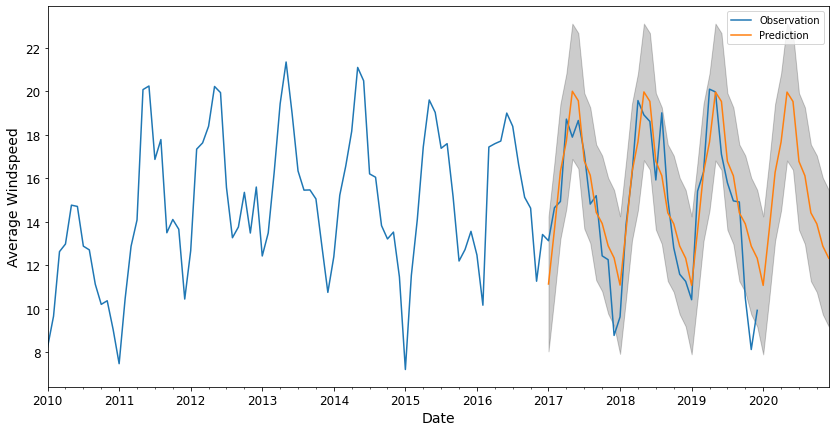

In [36]:
ax = y.plot(label='Observation', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Prediction')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Average Windspeed')

plt.legend()
plt.show()

# Heat Index Prediction using Linear Regression from sklearn

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [38]:
# https://stackabuse.com/using-machine-learning-to-predict-the-weather-part-2/

# Correlation values ranging from 0 to 1 represent increasingly strong positive correlation and
# Correlation values from 0 to -1 are said to be inversely, or negatively, correlated.
df.corr()[['HeatIndx']].sort_values('HeatIndx')


,HeatIndx
Humidity,-0.675183
Pressure,-0.547825
Precipitation,-0.074657
SnowDepth,-0.050312
Windspeed,0.193559
Dewpt,0.334267
Tmin,0.885377
Tmax,0.890273
Tavg,0.901066
Tobserved,0.996008


In [39]:
# Based on the correlation co-efficient for this linear regression model, we will be
# considering features with correlation value greater than absolute value of 0.0,
# Creating a dataframe out of the final feature set
# predictors = ['HLY-DEWP-10PCTL','HLY-DEWP-NORMAL','HLY-DEWP-90PCTL','HLY-TEMP-90PCTL','HLY-HIDX-NORMAL','HLY-WCHL-NORMAL','HLY-TEMP-NORMAL']
predictors = ['Dewpt','Windspeed','Tmax','Tmin','Tavg','Tobserved']
df2 = df[['HeatIndx']+predictors]
df2

,HeatIndx,Dewpt,Windspeed,Tmax,Tmin,Tavg,Tobserved
Date,,,,,,,
2010-01-01 00:00:00,2,-4,7,14,1,7.5,2
2010-01-01 01:00:00,2,-3,6,14,1,7.5,2
2010-01-01 02:00:00,2,-3,6,14,1,7.5,2
2010-01-01 03:00:00,2,-3,6,14,1,7.5,1
2010-01-01 04:00:00,1,-3,6,14,1,7.5,1
...,...,...,...,...,...,...,...
2019-12-31 19:00:00,9,-1,3,10,3,6.5,9
2019-12-31 20:00:00,8,-1,3,10,3,6.5,8
2019-12-31 21:00:00,8,-1,3,10,3,6.5,8


In [40]:
# import the relevant module
import statsmodels.api as sm

# separate our my predictor variables (X) from my outcome variable y
X = df2[predictors]
y = df2['HeatIndx']
# Add a constant to the predictor variable set to represent the Bo intercept
X = sm.add_constant(X)
X.iloc[:5, :5]
X=X.resample('MS').mean()
X

,const,Dewpt,Windspeed,Tmax,Tmin,Tavg,Tobserved
Date,,,,,,,
2010-01-01,1.0,-0.551075,8.231183,12.645161,2.741935,7.693548,6.739247
2010-02-01,1.0,0.555060,9.650298,13.571429,3.428571,8.500000,7.693452
2010-03-01,1.0,-4.493280,12.620968,16.580645,4.129032,10.354839,9.610215
2010-04-01,1.0,-1.819444,12.970833,18.700000,5.166667,11.933333,11.208333
2010-05-01,1.0,-3.168011,14.758065,23.000000,7.645161,15.322581,14.719086
...,...,...,...,...,...,...,...
2019-08-01,1.0,3.185484,14.954301,36.354839,21.967742,29.161290,29.467742
2019-09-01,1.0,2.618056,14.904167,30.433333,17.300000,23.866667,23.612500
2019-10-01,1.0,-7.423387,10.490591,23.709677,10.161290,16.935484,17.333333


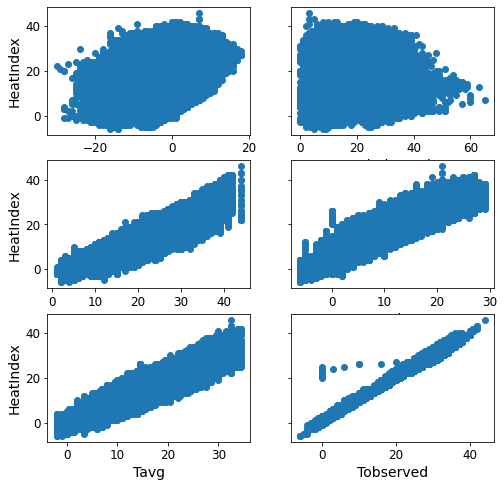

In [41]:
plt.rcParams['figure.figsize'] = [8,8]

fig, axes = plt.subplots(nrows=3, ncols=2, sharey=True)

arr = np.array(predictors).reshape(3,2)

for row, col_arr in enumerate(arr):
    for col, feature in enumerate(col_arr):
        axes[row, col].scatter(df2[feature], df2['HeatIndx'])
        if col == 0:
            axes[row, col].set(xlabel=feature, ylabel='HeatIndex')
        else:
            axes[row, col].set(xlabel=feature)
plt.show()

In [42]:
y=y.resample('MS').mean()
y

Date
2010-01-01     6.771505
2010-02-01     7.735119
2010-03-01     9.629032
2010-04-01    11.168056
2010-05-01    14.590054
                ...    
2019-08-01    29.166667
2019-09-01    23.848611
2019-10-01    17.767473
2019-11-01    13.540278
2019-12-01     7.793011
Freq: MS, Name: HeatIndx, Length: 120, dtype: float64

In [43]:
# (1) select a significance value
alpha = 0.05

# (2) Fit the model
model = sm.OLS(y, X).fit()

# (3) evaluate the coefficients' p-values
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               HeatIndx   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.923e+04
Date:                Mon, 18 May 2020   Prob (F-statistic):          2.25e-175
Time:                        19:54:47   Log-Likelihood:                 22.346
No. Observations:                 120   AIC:                            -32.69
Df Residuals:                     114   BIC:                            -15.97
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7376      0.140      5.276      0.000       0.461       1.015
Dewpt          0.0208      0.009      2.423      0.017       0.004       0.038
Windspeed     -0.0033      0.007     -0.446      0.657      -0.018       0.011
Tmax          -0.0468      0.023     -2.047      0.043      -0.092      -0.002
Tmin          -0.0789      0.032     -2.447      0.016      -0.143      -0.015
Tavg          -0.0628      0.025     -2.557      0.012      -0.112      -0.014
Tobserved      1.1281      0.072     15.758      0.000       0.986       1.270
==============================================================================
Omnibus:                       31.796   Durbin-Watson:                   1.056
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.189
Skew:                           1.184   Prob(JB):                     1.04e-12
Kurtosis:                       5.330   Cond. No.                     4.22e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.16e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

The next two parts has to be changed accordingly

In [44]:
# Identify the predictor with the greatest p-value and assess if its > our selected alpha.
#             based off the table it is clear that windspeed has the greatest p-value and that it is
#             greater than our alpha of 0.05

# Used pandas drop function to remove this column from X
X = X.drop('Windspeed', axis=1)

# (5) Fit the model 
model = sm.OLS(y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               HeatIndx   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 3.680e+04
Date:                Mon, 18 May 2020   Prob (F-statistic):          1.21e-177
Time:                        19:54:47   Log-Likelihood:                 22.242
No. Observations:                 120   AIC:                            -34.48
Df Residuals:                     115   BIC:                            -20.55
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6974      0.107      6.546      0.000       0.486       0.908
Dewpt          0.0205      0.009      2.398      0.018       0.004       0.037
Tmax          -0.0432      0.021     -2.026      0.045      -0.085      -0.001
Tmin          -0.0730      0.029     -2.493      0.014      -0.131      -0.015
Tavg          -0.0581      0.022     -2.632      0.010      -0.102      -0.014
Tobserved      1.1137      0.064     17.476      0.000       0.987       1.240
==============================================================================
Omnibus:                       34.646   Durbin-Watson:                   1.043
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               63.518
Skew:                           1.259   Prob(JB):                     1.61e-14
Kurtosis:                       5.522   Cond. No.                     4.43e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.29e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [45]:
X

,const,Dewpt,Tmax,Tmin,Tavg,Tobserved
Date,,,,,,
2010-01-01,1.0,-0.551075,12.645161,2.741935,7.693548,6.739247
2010-02-01,1.0,0.555060,13.571429,3.428571,8.500000,7.693452
2010-03-01,1.0,-4.493280,16.580645,4.129032,10.354839,9.610215
2010-04-01,1.0,-1.819444,18.700000,5.166667,11.933333,11.208333
2010-05-01,1.0,-3.168011,23.000000,7.645161,15.322581,14.719086
...,...,...,...,...,...,...
2019-08-01,1.0,3.185484,36.354839,21.967742,29.161290,29.467742
2019-09-01,1.0,2.618056,30.433333,17.300000,23.866667,23.612500
2019-10-01,1.0,-7.423387,23.709677,10.161290,16.935484,17.333333


In [46]:
# first remove the const column because unlike statsmodels, SciKit-Learn will add that in for us
X = X.drop('const', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=False)

In [47]:
# instantiate the regressor class
regressor = LinearRegression()

# fit the build the model by fitting the regressor to the training data
regressor.fit(X_train, y_train)

# make a prediction set using the test set
prediction = regressor.predict(X_test)

# Evaluate the prediction accuracy of the model
from sklearn.metrics import mean_absolute_error, median_absolute_error
print("The Explained Variance: %.2f" % regressor.score(X_test, y_test))
print("The Mean Absolute Error: %.2f degrees celsius" % mean_absolute_error(y_test, prediction))
print("The Median Absolute Error: %.2f degrees celsius" % median_absolute_error(y_test, prediction))

The Explained Variance: 1.00
The Mean Absolute Error: 0.29 degrees celsius
The Median Absolute Error: 0.18 degrees celsius


In [48]:
# print(X_test.shape,y_test.shape)
yy = pd.Series(y_test)
print(X_test.shape,X_train.shape)
X_test

(24, 5) (96, 5)


,Dewpt,Tmax,Tmin,Tavg,Tobserved
Date,,,,,
2018-01-01,-1.622312,15.451613,6.838710,11.145161,10.857527
2018-02-01,-5.558036,14.857143,5.142857,10.000000,9.688988
2018-03-01,-1.067204,15.967742,7.741935,11.854839,11.602151
2018-04-01,0.825000,22.700000,11.400000,17.050000,16.829167
2018-05-01,4.266129,25.645161,13.903226,19.774194,19.623656
2018-06-01,3.297222,33.266667,18.000000,25.633333,25.640278
2018-07-01,7.755376,37.193548,24.000000,30.596774,30.560484
2018-08-01,3.379032,35.322581,22.483871,28.903226,28.494624
2018-09-01,1.665278,32.666667,18.433333,25.550000,25.001389


In [49]:
df_1 = pd.DataFrame({'Actual': y_test, 'Predicted': prediction})
df_1

,Actual,Predicted
Date,,
2018-01-01,10.884409,10.865452
2018-02-01,9.718750,9.709632
2018-03-01,11.623656,11.578533
2018-04-01,16.709722,16.554167
2018-05-01,19.559140,19.243997
2018-06-01,24.920833,24.933602
2018-07-01,29.724462,29.655847
2018-08-01,27.446237,27.648128
2018-09-01,24.363889,24.313711


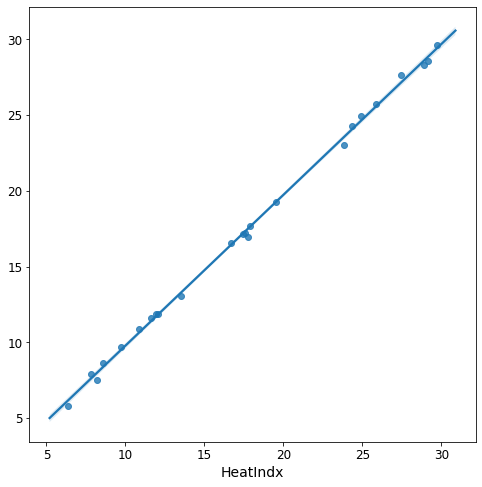

In [50]:
import seaborn as sns
sns.regplot(y_test, prediction)